# Convolutional networks for TF ChIP-seq data:  our version of DeepBind

This notebook provides a simple one layer convolutional network similar to the one proposed in the "DeepBind" paper.  We then extend the basic architecture to a multi-layer network.

In [1]:
import csv
import torch
from sklearn import metrics
from sklearn.model_selection import train_test_split

import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import os 
import warnings
#warnings.filterwarnings("ignore")

In [2]:
# if you have a GPU we should enable it
# mps is the pytorch device that supports GPU computations on MacOS

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Data

In [3]:
# datasets can be obtained e.g. from:
# https://github.com/MedChaabane/deepRAM/tree/master/datasets/ChIP-seq

# convert sequence to a one-hot encoding
# and pad with a uniform distribution
def seqtopad(sequence, motif_len):
    rows=len(sequence)+2*motif_len-2
    S=np.empty([rows,4])
    base=['A', 'C', 'G', 'T']
    for i in range(rows):
        for j in range(4):
            if (i-motif_len+1<len(sequence) and sequence[i-motif_len+1]=='N' 
                or i<motif_len-1 or i>len(sequence)+motif_len-2):
                S[i,j]=np.float32(0.25)
            elif sequence[i-motif_len+1]==base[j]:
                S[i,j]=np.float32(1)
            else:
                S[i,j]=np.float32(0)
    return np.transpose(S)

def load_file(path, motif_len=8):
    dataset=[]
    sequences=[]
    with open(path, 'rt') as file_handle:
        # skip the header:
        next(file_handle)
        reader = csv.reader(file_handle, delimiter='\t')
        for row in reader:
            sequence = row[2]
            label = int(row[3])
            dataset.append([seqtopad(sequence, motif_len),[label]])
            sequences.append(sequence)
    return dataset  

class chipseq_dataset(Dataset):
    def __init__(self, xy):
        self.x_data=np.asarray([el[0] for el in xy],dtype=np.float32)
        self.y_data =np.asarray([el[1] for el in xy ],dtype=np.float32)
        self.x_data = torch.from_numpy(self.x_data)
        self.y_data = torch.from_numpy(self.y_data)
        self.length=len(self.x_data)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length

In [4]:
file_name = "SRF_H1-hESC_SRF_HudsonAlpha_B.seq"
dataset=load_file(file_name)
train_data, valid_data = train_test_split(dataset, test_size=0.25)

In [5]:
len(train_data),len(valid_data)

(750, 250)

In [6]:
train_dataset=chipseq_dataset(train_data)
valid_dataset=chipseq_dataset(valid_data)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,shuffle=True)

## The model

Below is an implementation of a simple one-layer CNN, as described in the Deep-Bind paper.

In [7]:
class DeepBind(nn.Module):
    def __init__(self, num_kernels=8, kernel_size=12,
                 sigma_conv=1e-2, sigma_w=1e-2):
        super(DeepBind, self).__init__()
        #self.sigma_conv=sigma_conv
        #self.sigma_w=sigma_w
        self.input_channels=4
        self.num_kernels=num_kernels
        self.kernel_size=kernel_size
        self.conv_block = nn.Sequential(
            # first layer
            nn.Conv1d(in_channels=self.input_channels,
                      out_channels=num_kernels,
                      kernel_size=kernel_size),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )
        self.classification_block = nn.Sequential(
            nn.Linear(num_kernels, num_kernels),
            nn.ReLU(),
            nn.Dropout(p=0.2),            
            nn.Linear(num_kernels, 1),
            nn.Sigmoid()
        )            

    def forward(self, x):
        x = self.conv_block(x)
        x,_ = torch.max(x, dim=2)        
        x = self.classification_block(x)
        return x


In [8]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss = 0
    # set the model to training mode - important when you have 
    # batch normalization and dropout layers
    model.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        # backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0 :
        print(f"training loss: {total_loss/num_batches:>7f}")
    return total_loss / num_batches

def validation(dataloader, model, loss_fn, epoch):
    # set the model to evaluation mode 
    model.eval()
    # size of dataset
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss, correct = 0, 0
    # Evaluating the model with torch.no_grad() ensures that no gradients 
    # are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage 
    # for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            validation_loss += loss_fn(y_pred, y).item()
            pred = np.heaviside(y_pred.detach().cpu().numpy().reshape(len(y_pred))-0.5,0)
            correct += (pred == y.detach().cpu().numpy().reshape(len(y))).sum()
    validation_loss /= num_batches
    correct /= size
    if epoch%10 == 0 :
        print(f"Validation Accuracy: {correct:>8f}\nAvg validation loss: {validation_loss:>8f} \n")
    return validation_loss


In [21]:
model = DeepBind().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-06);

#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [22]:
epochs = 200
loss_fn = nn.BCELoss()

train_loss = []
validation_loss = []
for t in range(epochs):
    if t % 10 == 0 :
        print(f"Epoch {t}\n-------------------------------")
    loss = train_epoch(train_loader, model, loss_fn, optimizer, t)
    train_loss.append(loss)
    loss = validation(valid_loader, model, loss_fn, t)
    validation_loss.append(loss)
print("Done!")


Epoch 0
-------------------------------
training loss: 0.696590
Validation Accuracy: 0.492000
Avg validation loss: 0.696281 

Epoch 10
-------------------------------
training loss: 0.691719
Validation Accuracy: 0.484000
Avg validation loss: 0.693671 

Epoch 20
-------------------------------
training loss: 0.687319
Validation Accuracy: 0.520000
Avg validation loss: 0.691668 

Epoch 30
-------------------------------
training loss: 0.666200
Validation Accuracy: 0.576000
Avg validation loss: 0.681094 

Epoch 40
-------------------------------
training loss: 0.573967
Validation Accuracy: 0.796000
Avg validation loss: 0.577038 

Epoch 50
-------------------------------
training loss: 0.437929
Validation Accuracy: 0.836000
Avg validation loss: 0.450210 

Epoch 60
-------------------------------
training loss: 0.373128
Validation Accuracy: 0.808000
Avg validation loss: 0.420389 

Epoch 70
-------------------------------
training loss: 0.357289
Validation Accuracy: 0.840000
Avg validation lo

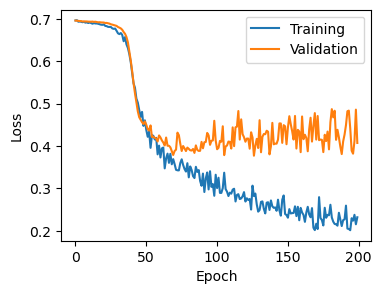

In [23]:
from matplotlib import pyplot as plt
plt.figure(figsize=(4,3))
plt.plot(train_loss, label='Training')
plt.plot(validation_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [24]:
with torch.no_grad():
    model.eval()
    pred_list = []
    labels_list = []
    for i, (data, target) in enumerate(valid_loader):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        pred=output.cpu().detach().numpy().reshape(output.shape[0])
        labels=target.cpu().numpy().reshape(output.shape[0])
        pred_list.append(pred)
        labels_list.append(labels)
    labels = np.concatenate(labels_list)
    predictions = np.concatenate(pred_list)
    auc = metrics.roc_auc_score(labels, predictions)
    print('AUC on validation data ', auc)


AUC on validation data  0.9151511270491802


### Model exploration

Explore the following aspects of the model:

* Number of convolutional filters
  * How many filters does the model need?
  * What happens when you use a very large number of filters?
* The optimizer and its parameters



### Visualizing convolutional filters

Next, we'll take a look at the weights of the convolutional filters learned by the model:

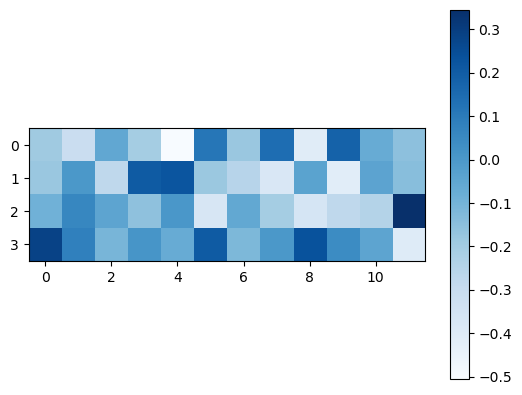

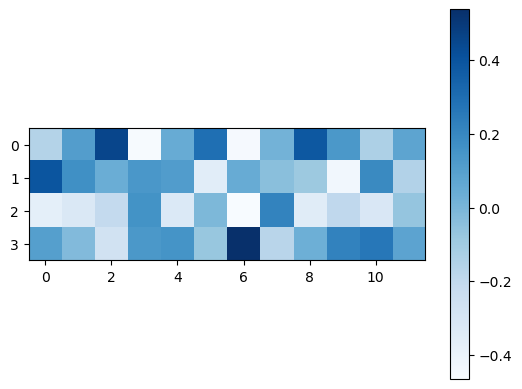

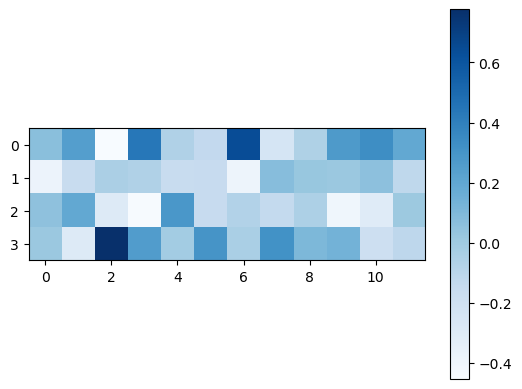

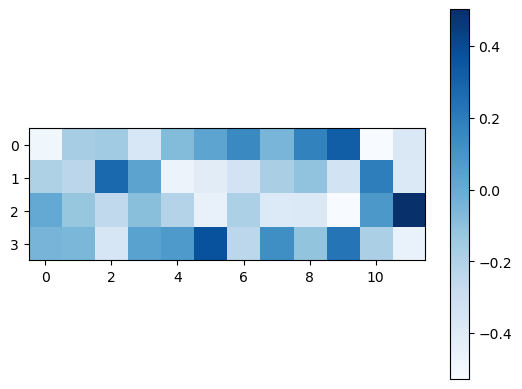

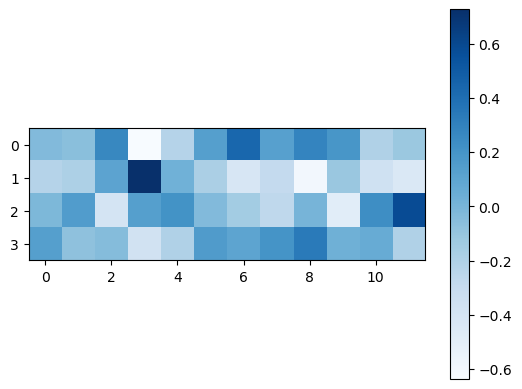

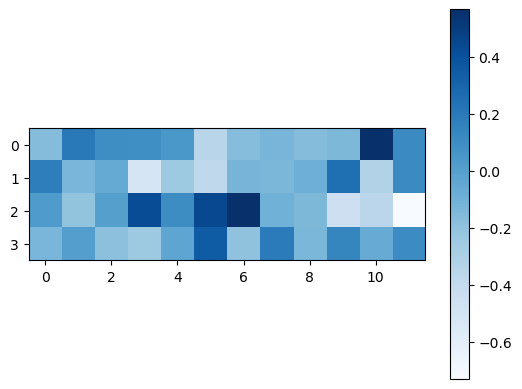

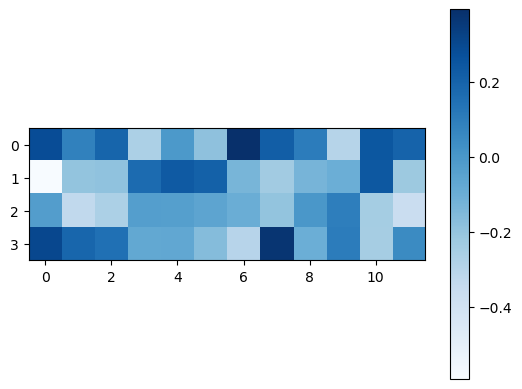

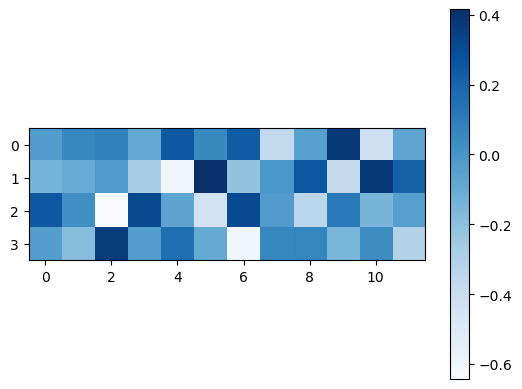

In [25]:
import matplotlib.pyplot as plt

# convert the convolutional filters to a numpy array:
weights=model.conv_block[0].weight.detach().cpu().numpy()

# plot the convolutional filters:
for filter in range(len(weights)) :
    fig = plt.figure()
    plt.imshow(weights[filter],cmap="Blues")
    plt.colorbar()

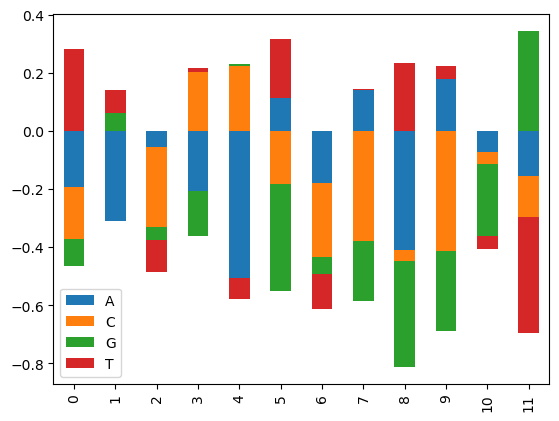

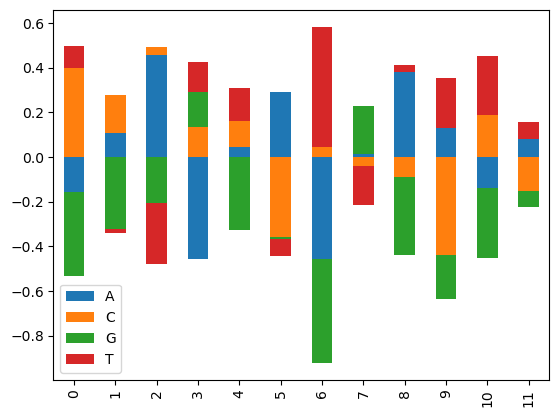

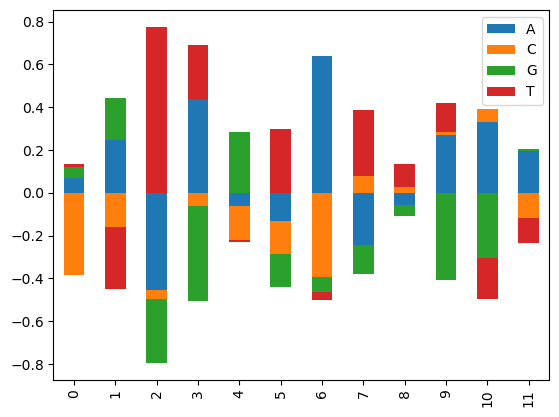

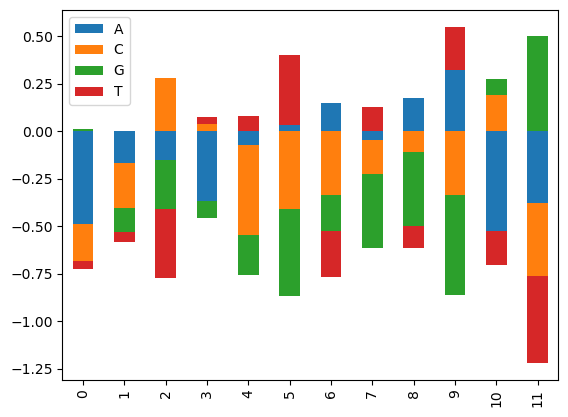

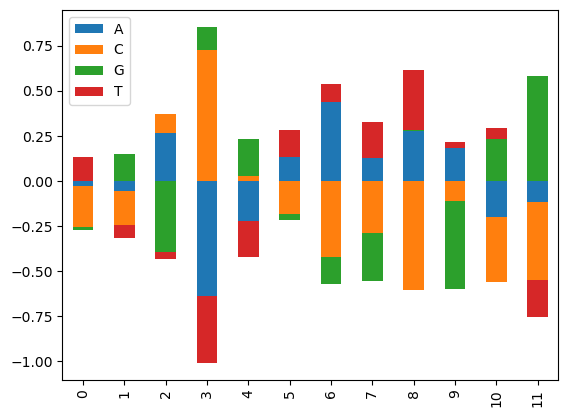

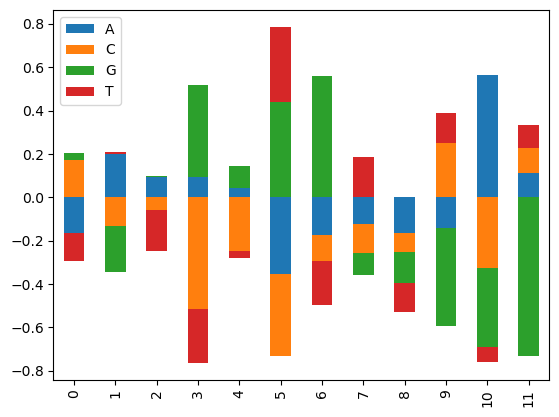

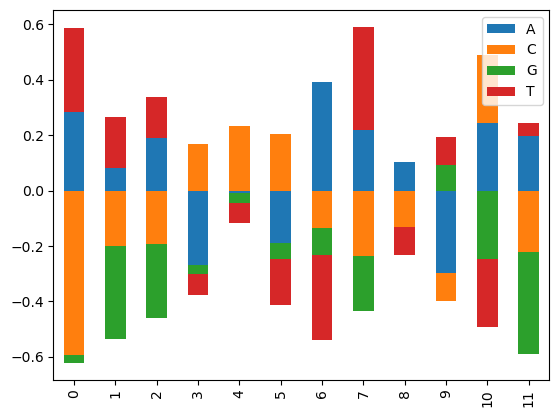

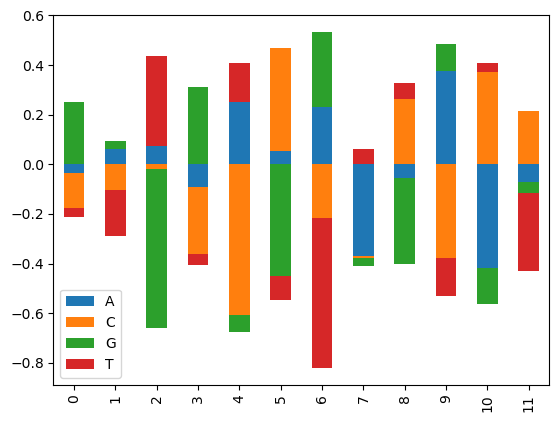

In [26]:
import pandas as pd
for filter in range(len(weights)) :
    filter_df = pd.DataFrame(weights[filter].T, columns=['A','C','G','T'])
    filter_df.plot.bar(stacked=True, use_index=True);

### From filters to motifs

You would think that the convolutional filter can be directly interpreted as a motif.  But that is not the case!  There are algorithms for extracting motifs from the first convolutional layer of a sequence-based CNN by extracting sequences that "activate" the filter, and using those as instances of the motif learned by the filter.

## A multi-layer convolutional network

Let's extend our previous network to a multi-layer network:

In [15]:
class DNA_CNN(nn.Module):
    def __init__(self, num_kernels=[8, 32], kernel_size=12,
                 sigma_conv=1e-2, sigma_w=1e-2):
        super(DNA_CNN, self).__init__()
        #self.sigma_conv=sigma_conv
        #self.sigma_w=sigma_w
        self.input_channels=4
        self.num_kernels=num_kernels
        self.kernel_size=kernel_size
        self.conv_block = nn.Sequential(
            # first layer
            nn.Conv1d(in_channels=self.input_channels,
                      out_channels=num_kernels[0],
                      kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=0.2),
            # second layer
            nn.Conv1d(in_channels=self.num_kernels[0],
                      out_channels=num_kernels[1],
                      kernel_size=kernel_size),
            nn.ReLU(),
            #nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=0.2),            
        )
        self.classification_block = nn.Sequential(
            nn.Linear(num_kernels[1], num_kernels[1]),
            nn.ReLU(),
            nn.Dropout(p=0.2),            
            nn.Linear(num_kernels[1], 1),
            nn.Sigmoid()
        )            

    def forward(self, x):
        x = self.conv_block(x)
        x,_ = torch.max(x, dim=2)        
        x = self.classification_block(x)
        return x


In [27]:
model = DNA_CNN().to(device)

optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01,momentum=0.9,nesterov=True, weight_decay=1e-06);

#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [28]:
epochs = 200
loss_fn = nn.BCELoss()

train_loss = []
validation_loss = []
for t in range(epochs):
    if t % 10 == 0 :
        print(f"Epoch {t}\n-------------------------------")
    loss = train_epoch(train_loader, model, loss_fn, optimizer, t)
    train_loss.append(loss)
    loss = validation(valid_loader, model, loss_fn, t)
    validation_loss.append(loss)
print("Done!")


Epoch 0
-------------------------------
training loss: 0.694758
Validation Accuracy: 0.488000
Avg validation loss: 0.694515 

Epoch 10
-------------------------------
training loss: 0.692486
Validation Accuracy: 0.488000
Avg validation loss: 0.693258 

Epoch 20
-------------------------------
training loss: 0.693026
Validation Accuracy: 0.492000
Avg validation loss: 0.693026 

Epoch 30
-------------------------------
training loss: 0.691621
Validation Accuracy: 0.516000
Avg validation loss: 0.692411 

Epoch 40
-------------------------------
training loss: 0.690906
Validation Accuracy: 0.548000
Avg validation loss: 0.691909 

Epoch 50
-------------------------------
training loss: 0.685496
Validation Accuracy: 0.548000
Avg validation loss: 0.690681 

Epoch 60
-------------------------------
training loss: 0.675543
Validation Accuracy: 0.604000
Avg validation loss: 0.683034 

Epoch 70
-------------------------------
training loss: 0.575438
Validation Accuracy: 0.792000
Avg validation lo

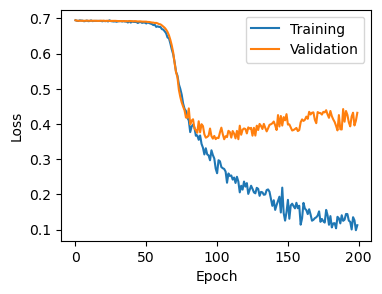

In [29]:
from matplotlib import pyplot as plt
plt.figure(figsize=(4,3))
plt.plot(train_loss, label='Training')
plt.plot(validation_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [30]:
with torch.no_grad():
    model.eval()
    pred_list = []
    labels_list = []
    for i, (data, target) in enumerate(valid_loader):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        pred=output.cpu().detach().numpy().reshape(output.shape[0])
        labels=target.cpu().numpy().reshape(output.shape[0])
        pred_list.append(pred)
        labels_list.append(labels)
    labels = np.concatenate(labels_list)
    predictions = np.concatenate(pred_list)
    auc = metrics.roc_auc_score(labels, predictions)
    print('AUC on validation data ', auc)


AUC on validation data  0.9138063524590164


Next, we'll take a look at the convolutional weights:

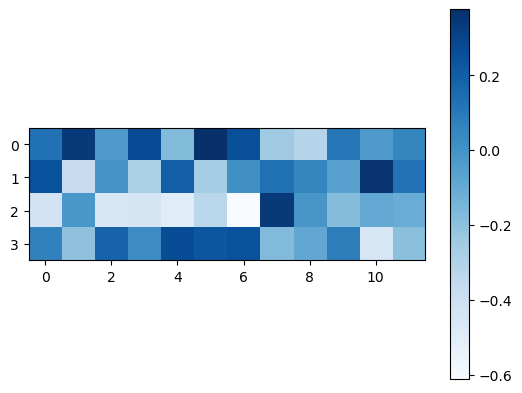

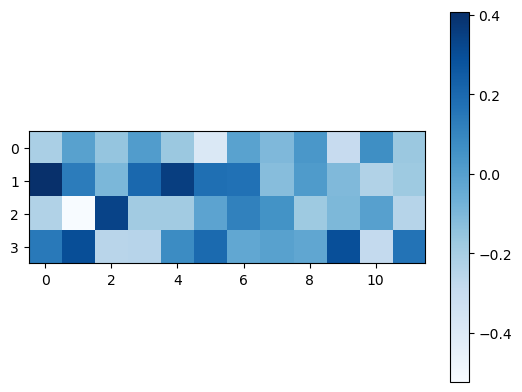

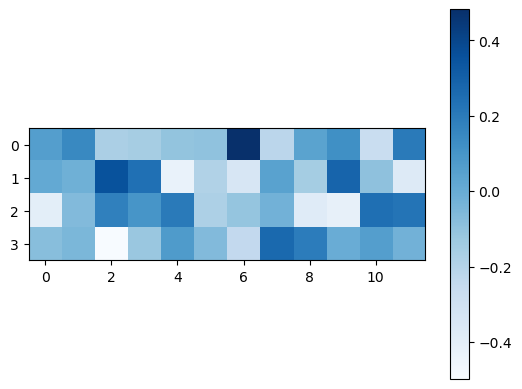

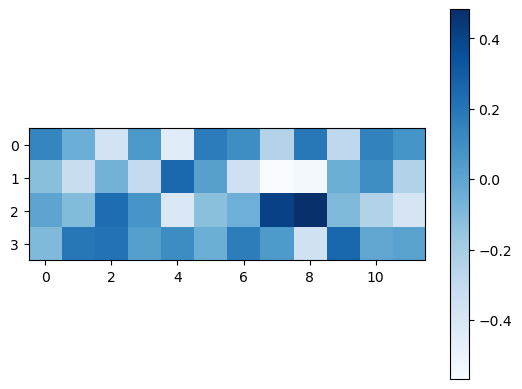

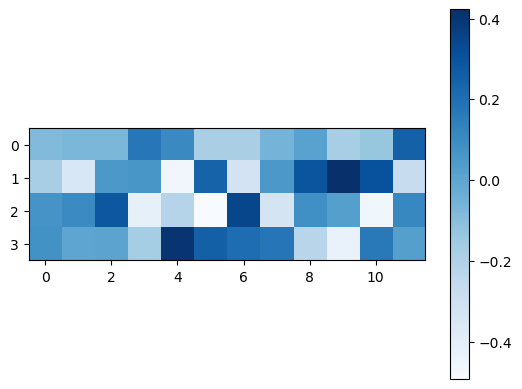

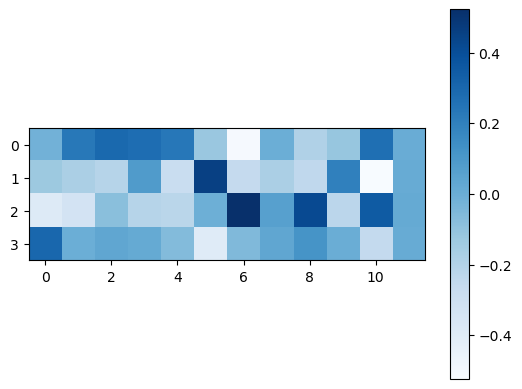

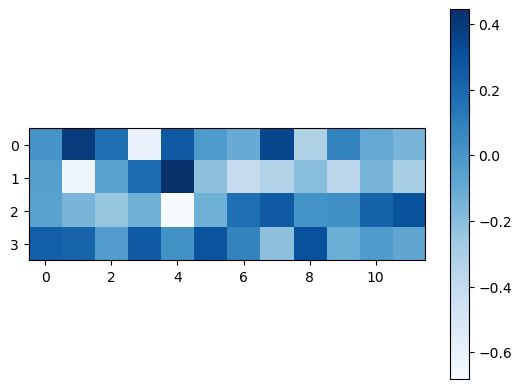

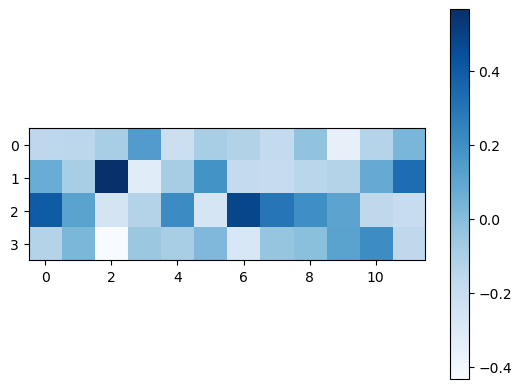

In [31]:
import matplotlib.pyplot as plt

# convert the convolutional filters to a numpy array:
weights=model.conv_block[0].weight.detach().cpu().numpy()

# plot the convolutional filters:
for filter in range(len(weights)) :
    fig = plt.figure()
    plt.imshow(weights[filter],cmap="Blues")
    plt.colorbar()